# Week 2

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append("../")
import edhec_risk_kit as erk

In [9]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Modern portfolio theory (MPT)

The **Modern portfolio theory (MPT)** is a mathematical framework **for assembling a portfolio of assets such that the expected return is maximized for a given level of volatility**. It is a formalization of **diversification in investing**, i.e., the idea that owning different kinds of financial assets is less risky than owning one signgle asset. 

### Efficient Frontiers 

In the MPT, the **efficient frontier** is a curve denoting the **efficient** part of the **volatility-return plane**. 
Formally, it is the set of portfolios that can be constructed with the given input assets 
that have the maximum expected returns for a fixed level of volatility and, in turn, 
the lowest volatilities for a fixed level of expected return. The efficient frontier was first formulated by **Harry Markowitz** (1952).

We have to construct a portfolio of several assets and **we want to find the optimal percentages of investment to be allocated in these assets** so that, for example, the total (expected) return of such a portfolio is maximixed for a given level of volatility. 

Suppose **we have $N > 1$ stocks** and we decide to invest our capital in them. 
Let $\mathbf{w}:=(w_1,\dots,w_N)^T$, with $w_i\in (0,1)$ for all $i=1,\dots,N$, 
where each $w_i$ represents the proportion of the investiment 
(a percentage of the capital invested) in asset $i$. 
These quantities $w_i$ are the **weights**.

Since we invest all of our capital, there holds $\sum_{i=1}^N w_i = 1$ (this is a **long-only** strategy).

Let $R_i$ and $R_p$ be the return of asset $i$ and the total return of the portfolio, respectively. 
Likewise, let $\sigma_i$ and $\sigma_p$ be the volatility of asset $i$ and the volatility of the portfolio, respectively. 


### Return of a portfolio
The **total return of the porfolio** is going to be a simple weigthed average of the (total) returns of single assets, i.e.,
$$
R_p = \sum_{i=1}^N w_i R_i = \mathbf{w}^T \mathbf{R},
$$
where $\mathbf{R} := (R_1,\dots,R_N)^T$. 
Note that if we have a dataset of **past returns**, the total return $R_p$ is computed as above using the returns of the past data. On the other hand, if we are going to invest now, we do not have a series of true (past) return, but we instead would have **expected returns**. Hence, in this case we would have the maean value $\mathbb{E}$ in the formula above. 


### Volatility of a portfolio
The **volatility of the porfolio** is computed as the (square root of the) variance of the weigthed sum of the returns of single assets. 

Let us consider an example with only two assets. 
We have $w_1$ and $w_2$ and two assets whose returns are $R_1$ and $R_2$. We have:
$$
\sigma_p^2 =   \text{Var}(w_1 R_1 + w_2 R_2) = 
w_1^2 \text{Var}(R_1) + w_2^2\text{Var}(R_2) + 2w_1 w_2\text{Cov}(R_1,R_2) =
w_1^2 \sigma_1^2 + w_2^2\sigma_2^2 + 2w_1 w_2\text{Cov}(R_1,R_2), 
$$
where 
$$
\text{Cov}(R_1,R_2) := \mathbb{E}[(R_1-\mu_1)(R_2 - \mu_2)], 
$$
is the **covariance** between the two assets and $\mu_i$ and $\mu_j$ denote 
their mean returns, respectively. In particular, if we let 
$$
\rho_{1,2} := \frac{\text{Cov}(R_1,R_2)}{\sigma_1 \sigma_2}, 
$$
denote the **correlation coefficient** between the assets, 
then the volatility of a $2$ assets portfolio becomes:
$$
\sigma_p = 
\sqrt{ w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2w_1 w_2 \sigma_1 \sigma_2 \rho_{1,2} }. 
$$
Note that, using matrix notation, we can write in compact form such a volatility. That is:
$$
\sigma_p = 
\sqrt{
(w_1, w_2)\, 
\begin{pmatrix}
\sigma^2_1 & \sigma_1 \sigma_2 \rho_{12} \\
\sigma_1 \sigma_2 \rho_{21} & \sigma^2_2
\end{pmatrix}
\begin{pmatrix}
w_1 \\
w_2 
\end{pmatrix}
}
=
\sqrt{
\mathbf{w}^T \Sigma \mathbf{w}
}
\quad\text{and}\quad
\Sigma := 
\begin{pmatrix}
\sigma^2_1 & \sigma_1 \sigma_2 \rho_{12} \\
\sigma_1 \sigma_2 \rho_{21} & \sigma^2_2
\end{pmatrix},
$$
where $\Sigma$ is the symmetric square **covariance matrix**.


Now, in case of $N$ stocks, let again $\Sigma = [c_{ij}]$ 
be the $N\times N$ covariance matrix 
where each element $c_{ij} := \sigma_i \sigma_j \rho_{ij}$, for $i,j=1,\dots,N$, 
denotes the **covariance** between assets $i$ 
and asset $j$, 
and with $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ being the volatilities 
and the correlation coefficients of assets $i$ and $j$, respectively.
Of course, when $i=j$, $c_{ii}=\sigma_i^2$ is simply the variance of asset $i$ 
(these are the diagonal entries of the covariance matrix).

The volatility of the portfolio is then given by:
$$
\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }.
$$


### Efficient frontiers of 2-assets portfolios 
In the following, we propose an artificial example in order to see the curve that is drawn by different portfolios which 
are constructed with only $2$ assets with different correlation $\rho_{12}$. 
First of all, we assume to generate $500$ **daily returns** of $2$ assets:

In [13]:
nret             = 500
periods_per_year = 252
risk_free_rate   = 0.0

Then, we set up a value for the means and the volatility of our two artifical assets:

In [14]:
mean_1 = 0.001019
mean_2 = 0.001249
vol_1  = 0.016317
vol_2  = 0.019129

and we set up $6$ correlations of the two assets, and for every fixed correlation, 
we will generate $20$ portfolios by allocating $20$ pairs of weights:

In [15]:
# Correlation goes from 1 (completely correlated) to -1 (conversely correlated)
rhos  = np.linspace(1,-1,num=6) 
ncorr = len(rhos)

# Pairs of weights to be used to construct the portfolios for any given correlation
nweig = 20
w1 = np.linspace(0,1,num=nweig)
w2 = 1 - np.linspace(0,1,num=nweig)
ww = pd.DataFrame( [w1, w2] ).T  

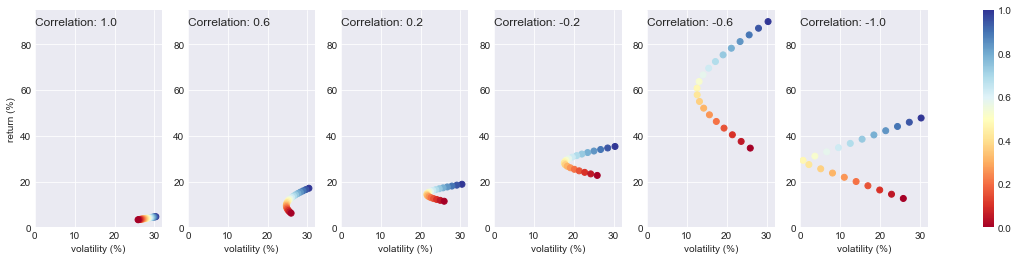

In [16]:
# Set seed
np.random.seed(1)

# Open the figure
fig, ax = plt.subplots(1,6, figsize=(20,4))    
ax = ax.flatten()

for k_rho, rho in enumerate(rhos):
    # Allocate an empty portfolio 
    portfolio = pd.DataFrame(columns=["return","volatility","sharpe ratio"])

    # Generate the assets' returns with the given correlation rho
    cov_ij     = rho * vol_1 * vol_2
    cov_rets   = pd.DataFrame( [[vol_1**2, cov_ij], [cov_ij, vol_2**2]] )
    daily_rets = pd.DataFrame( np.random.multivariate_normal((mean_1,mean_2), cov_rets.values, nret) )
    
    for i in range(ww.shape[0]):
        # Now, construct the portfolio of two asset with correlation rho and weights ww.loc[i]
        weights = ww.loc[i] 
        # here, weights is a column vector (pd.Series)

        # annualized portfolio returns
        ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
        portfolio_ret = erk.portfolio_return(weights, ann_rets)        

        # annualized portfolio volatility
        portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
        portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

        # annualized portfolio sharpe ratio
        portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)

        # dataframe containing the return, volatility, and the sharpe ratio of the portfolio constructed   
        portfolio = portfolio.append( {"return":portfolio_ret, "volatility": portfolio_vol, "sharpe ratio":portfolio_spr}, ignore_index=True)

    # plot create scatter plot coloured by Sharpe Ratio
    im = ax[k_rho].scatter(portfolio["volatility"]*100, portfolio["return"]*100, c=w2, cmap='RdYlBu') 
    ax[k_rho].grid()
    ax[k_rho].set_title("Correlation: {}".format(np.round(rho,2)), y=0.9, loc='left')
    ax[k_rho].set_xlabel("volatility (%)")
    if k_rho==0: ax[k_rho].set_ylabel("return (%)") 
    ax[k_rho].set_xlim([0,32])
    ax[k_rho].set_ylim([0,95])
    
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

For any given correlation, each point represents the pair (return, volatility) of a portfolio constructed with some percentage allocation. 
This can be seen in the colorbar: **red corresponds to $\mathbf{w} = (1,0)$**, i.e., allocation of money only to the first asset, whereas 
**blue corresponds to $\mathbf{w} = (0,1)$**, i.e., allocation of money only ot the second asset.  

We can see that **the lower the correlation between the assets, the better the trade-off between return and volatility**: in this example, 
when $\rho=-1$, we could in principle construct a portfolio which guarantees about $30\%$ of return with almost no volatility.

### Example from the real world: US stocks
Now we will get the timeseries of some US economy stocks and see how to construct a portfolio in an efficient way.

In [97]:
tickers  = ['AMZN','KO','MSFT']
n_assets = len(tickers) 

stocks = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stocks[stock_name] = data.DataReader(stock_name, data_source="yahoo", 
                                         start=datetime(2011,1,1), end=datetime(2019,1,1))["Adj Close"]   
    
stocks = round(stocks,2)

In [98]:
stocks#.tail()

,AMZN,KO,MSFT
Date,,,
2011-01-03,184.22,23.00,22.02
2011-01-04,185.01,22.52,22.10
2011-01-05,187.42,22.39,22.03
2011-01-06,185.86,22.22,22.68
2011-01-07,185.49,22.18,22.50
...,...,...,...
2018-12-24,1343.96,41.44,90.84
2018-12-26,1470.90,42.32,97.04
2018-12-27,1461.64,42.86,97.64


In [99]:
# compute the daily returns 
daily_rets = erk.compute_returns(stocks)
daily_rets#.tail()

,AMZN,KO,MSFT
Date,,,
2011-01-03,NaN,NaN,NaN
2011-01-04,0.004288,-0.020870,0.003633
2011-01-05,0.013026,-0.005773,-0.003167
2011-01-06,-0.008324,-0.007593,0.029505
2011-01-07,-0.001991,-0.001800,-0.007937
...,...,...,...
2018-12-24,-0.024313,-0.033807,-0.041671
2018-12-26,0.094452,0.021236,0.068252
2018-12-27,-0.006295,0.012760,0.006183


In [100]:
# Annualize returns (periods = 252)
ann_rets = erk.annualize_rets(daily_rets, 252)
round(ann_rets,2)

AMZN    0.30
KO      0.08
MSFT    0.21
dtype: float64

In [101]:
# compute the mean daily returns and the covariance of daily returns of the two assets
mean_rets = daily_rets.mean()
std_rets  = daily_rets.std()
cov_rets  = daily_rets.cov()
cov_rets

,AMZN,KO,MSFT
AMZN,0.000397,0.000047,0.000137
KO,0.000047,0.000082,0.000049
MSFT,0.000137,0.000049,0.000213


Now we simulate $4000$ portfolios with weights allocated to the stocks above:

In [102]:
periods_per_year = 252
num_portfolios   = 4000
portfolios       = pd.DataFrame(columns=["return","volatility","sharpe ratio","w1","w2","w3"])
risk_free_rate   = 0

In [103]:
for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    # and rescale them to sum to 1
    weights /= np.sum(weights)
    
    # annualized portfolio returns
    #ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
    portfolio_ret = erk.portfolio_return(weights, ann_rets)        

    # annualized portfolio volatility
    portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
    portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

    # annualized portfolio sharpe ratio
    portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)
    
    # create dataframe   
    portfolios = portfolios.append( {"return":portfolio_ret, 
                                     "volatility":portfolio_vol, 
                                     "sharpe ratio":portfolio_spr, 
                                     "w1": weights[0], "w2": weights[1], "w3": weights[2]}, 
                                     ignore_index=True)

In [104]:
portfolios.tail()

,return,volatility,sharpe ratio,w1,w2,w3
3995,0.185357,0.179503,1.032615,0.153199,0.278419,0.568382
3996,0.152506,0.159723,0.954820,0.043099,0.457451,0.499449
3997,0.157349,0.160338,0.981358,0.073716,0.441977,0.484307
3998,0.253614,0.236536,1.072197,0.519880,0.011125,0.468995
3999,0.203838,0.193546,1.053174,0.220219,0.181562,0.598219


Now we create a scatter plot coloured by sharpe ratios of the portfolios generated above and we also plot the efficient frontier:

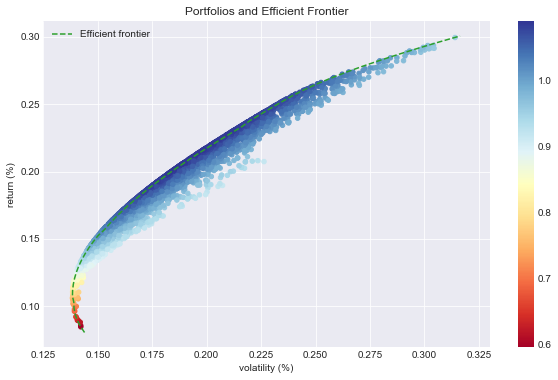

In [105]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, cmap='RdYlBu')
ax.set_title("Portfolios and Efficient Frontier")
ax.set_ylabel("return (%)")
ax.grid()

# Draw the efficient frontier
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="tab:green", ax=ax, grid=True, label="Efficient frontier")
ax.set_xlim([0.125,0.33])
ax.set_xlabel("volatility (%)")

fig.colorbar(im, ax=ax)
plt.show()

**We will come back to the plot of the efficient frontier below**.

We can see that if the investor is targeting **a return of $20\%$** he could simply hold 
a portfolio **with volatility of about $17.5\%$**, although there are many other portfolios that 
can guarantee the same return but with much higher volatilities such as $22.5\%$. 
It is clear that one should carefully choose the weights of the portfolio. 

We can see, in particular, that there are **two important** portfolios:

1. the **portfolio with the Global Minimum Volatility (GMV)**, i.e., the global minimum variance portfolio
2. the **portfolio with the Maximum Sharpe Ratio (MSR)**.

From the code above we can easily locate these two portfolios in our dataframe by looking at the lowest volatility and highest sharpe ratio 
and and recover the corresponding weights that have been stored.

In [106]:
# find the portfolio with lowest volatility 
low_vol_portfolio = portfolios.iloc[ portfolios['volatility'].idxmin() ]
print("Global Minimum Volatility portfolio:")
print("- return      : {:.2f}%".format(low_vol_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(low_vol_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(low_vol_portfolio[2]) )

# find the portfolio with highest sharpe ratio
high_sharpe_portfolio = portfolios.iloc[ portfolios['sharpe ratio'].idxmax() ]
print("Maximum Sharpe Ratio portfolio:")
print("- return      : {:.2f}%".format(high_sharpe_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(high_sharpe_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(high_sharpe_portfolio[2]) )

Global Minimum Volatility portfolio:
- return      : 10.59%
- volatility  : 13.84%
- sharpe ratio: 0.77
Maximum Sharpe Ratio portfolio:
- return      : 21.06%
- volatility  : 19.33%
- sharpe ratio: 1.09


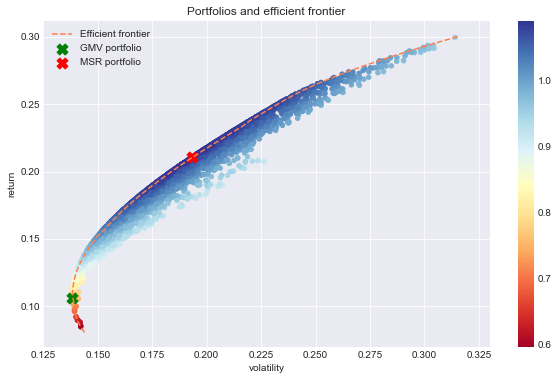

In [107]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, label=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.scatter(low_vol_portfolio[1],     low_vol_portfolio[0],     marker="X", color='g', s=120, label="GMV portfolio")
ax.scatter(high_sharpe_portfolio[1], high_sharpe_portfolio[0], marker="X", color='r', s=120, label="MSR portfolio")

ax.set_xlim([0.125,0.33])
ax.legend()

fig.colorbar(im, ax=ax)
plt.show()

Let us define the following function which we are going to use several time in what follows:

In [108]:
def get_portfolio_features(weights, rets, covmat, risk_free_rate, periods_per_year):
    # portfolio volatility
    vol = erk.portfolio_volatility(weights, covmat)
    vol = erk.annualize_vol(vol, periods_per_year)

    # portfolio return
    ret = erk.portfolio_return(weights, rets)

    # portfolio sharpe ratio
    shp = erk.sharpe_ratio(ret, risk_free_rate, periods_per_year, v=vol)

    print("Portfolio return:       {:.2f}%" .format(ret*100))
    print("Portfolio volatility:   {:.2f}%" .format(vol*100))
    print("Portfolio sharpe ratio: {:.2f}" .format(shp))
    
    return ret, vol, shp

### Finding the optimal portfolios: minimizing the volatility 

In the experiments above, we found the optimal portfolios, i.e., the ones on the efficient frontier, by **simulating a high number of portfolios** and then plotting them. From the plot we could see what the efficient frontier looked like. 
However, we can find an optimal portfolio on the efficient frontier by **solving a minimization problem**, 
for example, by applying the **scipy optimize** method. 


For example, suppose we want to **find the portfolio (on the efficient frontier) which has the minimum volatility**. 
Then the minimization problem is:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

In [109]:
# Let us see the total (annual) returns of single companies we are investing in
ann_rets = erk.annualize_rets(daily_rets, periods_per_year)
ann_rets

AMZN    0.300595
KO      0.080542
MSFT    0.205640
dtype: float64

Now, we can call our minimizer which solves the minimization problem of finding the weights of the portfolio with minimum volatility. 

In [110]:
optimal_weights = erk.minimize_volatility(ann_rets, cov_rets)
print("optimal weights:")
print("  AMZN: {:.2f}%".format(optimal_weights[0]*100))
print("  KO:   {:.2f}%".format(optimal_weights[1]*100))
print("  MSFT: {:.2f}%".format(optimal_weights[2]*100))

optimal weights:
  AMZN: 4.76%
  KO:   81.77%
  MSFT: 13.47%


Let us compute the volatility of the portfolio constructed with these weights and locate it on the efficient frontier:

Portfolio return:       10.79%
Portfolio volatility:   13.84%
Portfolio sharpe ratio: 0.78


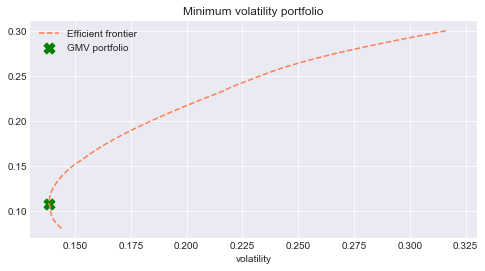

In [111]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='g', s=120, label="GMV portfolio")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Minimum volatility portfolio")
plt.show()

We can also verify that the minimum volatility portfolio obtained by solving the minimization problem almost coincides 
with the one obtained from simulating a high number of portfolios as we have done before: 

In [112]:
print("GMV portfolio:\n")
print("- Monte carlo:")
print("  return:       {:.2f}%" .format(low_vol_portfolio[0]*100))
print("  volatility:   {:.2f}%" .format(low_vol_portfolio[1]*100))
print("  sharpe ratio: {:.2f}" .format(low_vol_portfolio[2]))
print("\n- Minimization problem:")
print("  return:       {:.2f}%" .format(ret*100))
print("  volatility:   {:.2f}%" .format(vol*100))
print("  sharpe ratio: {:.2f}" .format(shp))

GMV portfolio:

- Monte carlo:
  return:       10.59%
  volatility:   13.84%
  sharpe ratio: 0.77

- Minimization problem:
  return:       10.79%
  volatility:   13.84%
  sharpe ratio: 0.78


#### Finding the optimal portfolios: minimizing the volatility given a fixed return

What if we want to find the **portfolio (on the efficient frontier) with minimium volatility for a given a level of return**? 
In this case, we simply have to add a constrain in the minimization problem:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0, \\
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$
where $R_0$ denotes a fixed level of expected return. For example, suppose we target the following total expected return $R_0=16\%$:

In [113]:
target_return = 0.16

Now, we can call again the minimizer with the option of solving the problem with the constrain for the given target return:

In [114]:
optimal_weights = erk.minimize_volatility(ann_rets, cov_rets, target_return)
print("optimal weights:")
print("  AMZN: {:.2f}%".format(optimal_weights[0]*100))
print("  KO:   {:.2f}%".format(optimal_weights[1]*100))
print("  MSFT: {:.2f}%".format(optimal_weights[2]*100))

optimal weights:
  AMZN: 17.98%
  KO:   50.13%
  MSFT: 31.88%


Let us compute the volatility of the portfolio constructed with these weights. 
Also, we double check that the corresponding return is the target return that we have chosen (i.e., $16\%$) and 
locate the portfolio on the efficient frontier:

Portfolio return:       16.00%
Portfolio volatility:   15.48%
Portfolio sharpe ratio: 1.03


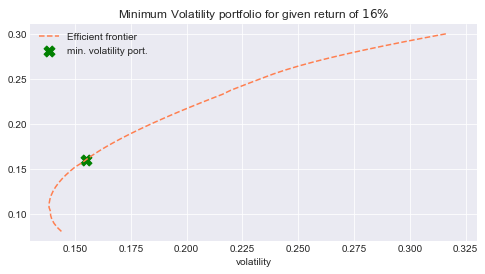

In [115]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, target_return,  marker="X", color='g', s=120, label="min. volatility port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Minimum Volatility portfolio for given return of $16\%$")
plt.show()

Recall that **the return of a portfolio will be some value between the minimum and the maximum return from the assets composing the portfolio**. That is, given the same three companies, we cannot achieve a return of, say $40\%$ since the maximum return achievable is about $30\%$ from Amazon. 
In fact, if we run the minimizer with a target return equal to $40\%$ we will get zero weights to all assets but Amazon:

In [116]:
optimal_weights = erk.minimize_volatility(ann_rets, cov_rets, 0.4)
print("optimal weights:")
print("  AMZN: {:.2f}%".format(optimal_weights[0]*100))
print("  KO:   {:.2f}%".format(optimal_weights[1]*100))
print("  MSFT: {:.2f}%".format(optimal_weights[2]*100))

optimal weights:
  AMZN: 100.00%
  KO:   0.00%
  MSFT: 0.00%


### Finding the optimal portfolios: maximizing the sharpe ratio 

Now, consider the case of finding **the portfolio (on the efficient frontier) with the highest sharpe ratio**. 

Note that scipy offers a **minimize** method, but no a **maximize** a method, and we may then conclude 
that we are not able to find such a portfolio by solving an optimization problem. 
However, **the maximization of the sharpe ratio is nothing but the minimization of the negative sharpe ratio**. 
That is, we have 
$$
\text{minimize} \;\; -  \frac{R_p - r_f}{\sigma_p} =: \text{SR} 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

Let us use our minimizer:

In [117]:
optimal_weights = erk.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
print("optimal weights:")
print("  AMZN: {:.2f}%".format(optimal_weights[0]*100))
print("  KO:   {:.2f}%".format(optimal_weights[1]*100))
print("  MSFT: {:.2f}%".format(optimal_weights[2]*100))

optimal weights:
  AMZN: 36.95%
  KO:   24.75%
  MSFT: 38.31%


Portfolio return:       20.98%
Portfolio volatility:   19.26%
Portfolio sharpe ratio: 1.09


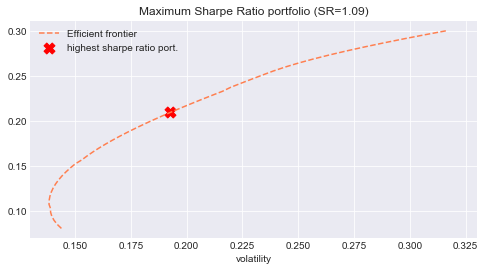

In [118]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='r', s=120, label="highest sharpe ratio port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Maximum Sharpe Ratio portfolio (SR={:.2f})".format(shp))
plt.show()

and let us see how these numbers differ from those obtained from the Monte Carlo simulation:

In [119]:
print("MSR portfolio:\n")
print("- Monte carlo:")
print("  return:       {:.2f}%" .format(high_sharpe_portfolio[0]*100))
print("  volatility:   {:.2f}%" .format(high_sharpe_portfolio[1]*100))
print("  sharpe ratio: {:.2f}" .format(high_sharpe_portfolio[2]))
print("\n- Minimization problem:")
print("  return:       {:.2f}%" .format(ret*100))
print("  volatility:   {:.2f}%" .format(vol*100))
print("  sharpe ratio: {:.2f}" .format(shp))

MSR portfolio:

- Monte carlo:
  return:       21.06%
  volatility:   19.33%
  sharpe ratio: 1.09

- Minimization problem:
  return:       20.98%
  volatility:   19.26%
  sharpe ratio: 1.09


#### Finding the optimal portfolios: maximize the sharpe ratio given a fixed volatility 

Similarly to what we have done before, we can find the **portfolio (on the efficient frontier) with highest sharpe ratio 
for a given a level of volatility**. In this case, we simply add a constrain in the minimization problem:
$$
\text{minimize} \;\; -  \frac{R_p - r_f}{\sigma_p} =: \text{SR} 
$$
subject to 
$$
\begin{cases}
\frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w} = \sigma_0, \\
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$
where $\sigma_0$ denotes a fixed level of volatility. For example, suppose we target the following total volatility of $\sigma_0=20\%$:

In [120]:
target_volatility = 0.2
optimal_weights = erk.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year, target_volatility)
print("optimal weights:")
print("  AMZN: {:.2f}%".format(optimal_weights[0]*100))
print("  KO:   {:.2f}%".format(optimal_weights[1]*100))
print("  MSFT: {:.2f}%".format(optimal_weights[2]*100))

optimal weights:
  AMZN: 39.47%
  KO:   20.32%
  MSFT: 40.21%


Portfolio return:       21.77%
Portfolio volatility:   20.00%
Portfolio sharpe ratio: 1.09


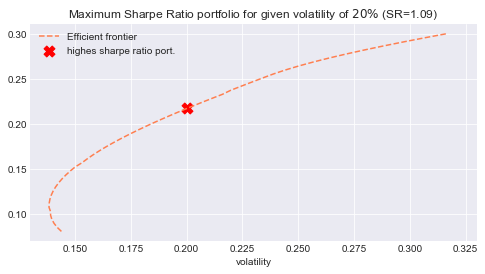

In [121]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='r', s=120, label="highes sharpe ratio port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Maximum Sharpe Ratio portfolio for given volatility of $20\%$ (SR={:.2f})".format(shp))
plt.show()

### Observation on constraints

It is worth mentioning that so far we have decided to invest all of our capital and, at the same time, our strategy has been **long-only**. That is, the weights that we allocate to the assets sum to $1$ 
and all of them are positive (because we **buy** the assets). 
In particular, these two conditions were imposed when solving the minimization problems. 

However, **we could in principle not invest all of our capital**, which means that we at do not necessarily 
get weights that sum to $1$, and also we may decide to not buy all the assets. We could **short selling** some of them (by short shelling we mean selling an asset that we do not have and that we borrow from someone else).

#### Short selling and not normalized weigths: minimum volatility portofolio given a fixed return 

We can solve the minimization problem without imposing the constraint on positive weigths and the constraint that the weights sum to $1$, i.e., simply:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0, 
\end{cases}
$$
in the case of finding the minimum volatility portfolio for a fixed return. 
In this case we are allowed to **short sell** the asset and in principle we do not have to invest all of our capital.

For such a problem we can find the analytical solution to the problem by using the **Lagrange multipliers**. 
We define the **Lagrangian** of the problem:
$$
\mathcal{L}(\mathbf{w}, \lambda) := \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w} - \lambda(  \mathbf{w}^T \mathbf{R} - R_0 ),
$$
and put the partial derivatives to zero:
$$
\begin{cases}
\frac{\partial\mathcal{L}}{\partial \mathbf{w}} &= \frac{1}{2} (2\Sigma \mathbf{w}) - \lambda  \mathbf{R} = 0, \\
\frac{\partial\mathcal{L}}{\partial \lambda} &=  - \mathbf{w}^T \mathbf{R} + R_0 = 0.
\end{cases}
$$
From the first equation, we get:
$$
\Sigma \mathbf{w} - \lambda  \mathbf{R} = 0 
\quad\Longrightarrow\quad 
\mathbf{w} = \lambda \Sigma^{-1}\mathbf{R},  
$$
and inserting in the second equation:
$$
- ( \lambda \Sigma^{-1}\mathbf{R} )^T \mathbf{R} + R_0 = 0 
\quad\Longrightarrow\quad 
\lambda \mathbf{R}^T \Sigma^{-1} \mathbf{R} = R_0
\quad\Longrightarrow\quad 
\lambda = \frac{R_0}{\mathbf{R}^T \Sigma^{-1} \mathbf{R}}.
$$
Note that since $\Sigma$ was symmetric, so is $\Sigma^{-1}$, from which $(\Sigma^{-1})^T = \Sigma^{-1}$. 
We can then insert $\lambda$ back into the first equation and obtain:
$$
\mathbf{w}^* = R_0 \frac{\Sigma^{-1}\mathbf{R}}{\mathbf{R}^T \Sigma^{-1} \mathbf{R}},
$$
which is therefore the analytical expression for the weights. Notice that since we have not imposed the constraint 
on the normalisation, we are not guaranteed that such vector of weights sum to $1$. 

#### Short selling and normalized weigths: minimum volatility portofolio given a fixed return 

Analogously, we can also also fin the analytical expression of optimal weights in case we add the condition that the weigths sum to $1$, but without requiring that they have to be all positive, i.e.:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} &= R_0,  \\
\mathbf{w}^T \mathbf{1} &= 1.
\end{cases}
$$
This is again the case in which we can **short sell** the asset but this time we invest all of the capital. 

We define the Lagrangian:
$$
\mathcal{L}(\mathbf{w}, \lambda) := \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w} 
- \lambda( \mathbf{w}^T \mathbf{R} - R_0) - \delta(\mathbf{w}^T\mathbf{1}-1),
$$
and put the partial derivatives to zero:
$$
\begin{cases}
\frac{\partial\mathcal{L}}{\partial \mathbf{w}} &= \frac{1}{2} (2\Sigma \mathbf{w}) - \lambda \mathbf{R} - \delta \mathbf{1}= 0, \\
\frac{\partial\mathcal{L}}{\partial \lambda} &=  - \mathbf{w}^T \mathbf{R} + R_0 = 0, \\
\frac{\partial\mathcal{L}}{\partial \lambda} &=  - \mathbf{w}^T \mathbf{1} + R_0 = 0.
\end{cases}
$$
From the first equation we get:
$$
\mathbf{w} = \Sigma^{-1}(\lambda \mathbf{R} + \delta\mathbf{1}), 
$$
and we can insert it in the second and the third equation, respectively:
\begin{cases}
\left(\Sigma^{-1}(\lambda \mathbf{R} + \delta\mathbf{1}) \right)^T\mathbf{R} 
&= \lambda \mathbf{R}^T\Sigma^{-1}\mathbf{R} + \delta\mathbf{1}\Sigma^{-1}\mathbf{R} = R_0, \\
\left(\Sigma^{-1}(\lambda \mathbf{R} + \delta\mathbf{1}) \right)^T\mathbf{1} 
&= \lambda \mathbf{R}^T\Sigma^{-1}\mathbf{1} + \delta\mathbf{1}\Sigma^{-1}\mathbf{1} = 1.
\end{cases}
Let us define the following fixed numbers:
$$
\begin{cases}
A & := \mathbf{R}^T \Sigma^{-1} \mathbf{R},  \\
B & := \mathbf{1}^T \Sigma^{-1} \mathbf{R} \equiv \mathbf{R}^T \Sigma^{-1} \mathbf{1}, \\
C & := \mathbf{1}^T \Sigma^{-1} \mathbf{1},
\end{cases}
$$
where notice that in B the second equation is true since $\Sigma^{-1}$ is a symmetric matrix. Hence we have the following system to solve:
$$
\begin{cases}
\lambda A + \delta B &= R_0, \\
\lambda B + \delta C &= 1.
\end{cases}
$$
From the second equation we find $\lambda$ and put it into the first equation:
$$
\lambda = \frac{1-\delta C}{B}
\quad\Longrightarrow\quad 
\frac{1-\delta C}{B} A + \delta B = R_0
\quad\text{from which we find}\quad
\delta = \frac{R_0B - A}{B^2-AC}.
$$
Now, we put $\delta$ back into $\lambda$:
$$
\lambda = \frac{1 - \frac{R_0 B-A}{B^2-AC}C }{B} = \frac{B - R_0 C}{B^2-AC}.
$$
Finally, we can put both $\lambda$ and $\delta$ we have just find back into $\mathbf{w}$ and find the optimal weight:
$$
\mathbf{w}^*  
= \lambda \Sigma^{-1} \mathbf{R} + \delta \Sigma^{-1} \mathbf{1} 
= \frac{B - R_0 C}{B^2-AC} \Sigma^{-1} \mathbf{R}  +  \frac{R_0B - A}{B^2-AC}  \Sigma^{-1}\mathbf{1} 
= \underbrace{ \frac{1}{B^2-AC}\left(B\Sigma^{-1}\mathbf{R} - A\Sigma^{-1}\mathbf{1} \right) }_{:= \mathbf{f} }
+ R_0 \Bigl( \underbrace{ \frac{1}{B^2-AC}\left(B\Sigma^{-1}\mathbf{1} - C\Sigma^{-1}\mathbf{R} \right) }_{:= \mathbf{g} }  \Bigr)
= \mathbf{f} + R_0 \mathbf{g}.
$$

### Maximizing the sharpe ratio portfolio in presence of non null risk-free rate

Recall that a **risk-free asset** is an (hypothetical) asset with a risk-free rate. For example, **short-term government securities (such as US treasury bills)** are used as a risk-free asset since **they pay a fixed interest rate and have exceptionally low default risk**. 

The risk-free asset has zero volatility. Furthermore, it is also uncorrelated with any other asset since, 
by definition, its volatility is zero. Therefore, when combined with any other asset in a portfolio, 
**the change in return is linearly related to the change in risk** as the proportions in the combination vary.

#### The capital market line (CML)

When a risk-free asset is introduced, there will be a line satisfying:

 1. it is tangent to the curve at the risky portfolio with the highest Sharpe ratio; 
 2. its vertical intercept represents a portfolio with $100\%$ of holdings in the risk-free asset; 
 3. the tangency with the curve represents the highest sharpe ratio portfolio with no risk-free holdings and $100%$ of risky assets; 
 assets held in the portfolio occurring at the tangency point; 
 4. points on this line represent portfolios containing positive amounts of both the risky assets and the risk-free asset; 
 
This efficient line is called the **Capital Market Line (CML)**, and its given by:
$$
R_{CML} = R_{f} + \sigma_{CML}\frac{R_{p} - R_{f}}{\sigma_{p}}, 
$$
where $R_p$ and $\sigma_p$ are the return and the volatility of the risky portfolio with no risk free asset, respectively, 
$R_f$ denotes the risk-free rate, and $R_{CML}$ and $\sigma_{CML}$ denote the return and the volatility of the 
portfolio combining both risky assets and the risk-free asset, respectively.

In [122]:
risk_free_rate = 0.06
optimal_weights = erk.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
print("optimal weights:")
print("  AMZN: {:.2f}%".format(optimal_weights[0]*100))
print("  KO:   {:.2f}%".format(optimal_weights[1]*100))
print("  MSFT: {:.2f}%".format(optimal_weights[2]*100))

optimal weights:
  AMZN: 55.63%
  KO:   0.00%
  MSFT: 44.37%


In [123]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

Portfolio return:       25.85%
Portfolio volatility:   24.20%
Portfolio sharpe ratio: 0.82


Let us plot the efficient frontier and the capital market line using the optional argument in our plot method:

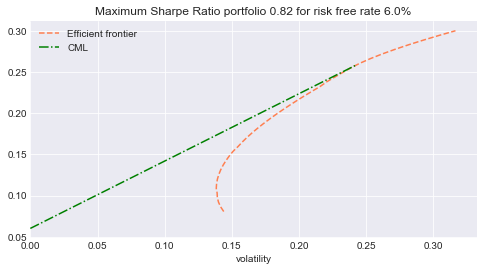

In [124]:
df, ax = erk.efficient_frontier(40, daily_rets, cov_rets, periods_per_year, risk_free_rate=risk_free_rate, 
                                iplot=True, cml=True)
ax.set_title("Maximum Sharpe Ratio portfolio {} for risk free rate {}%".format(np.round(shp,2),risk_free_rate*100))
plt.show()

The introduction of the risk-free asset as a possible component of the portfolio has improved the range of volatility-return combinations available since **everywhere, except at the tangency portfolio, the CML provides a higher return than the (old) efficient frontier does 
at every possible volatility.** 

Note that the efficient frontier method has other optional parameter to plot the highest sharpe ratio, the minimum volatility, and the equally weigthed portfolio as well:

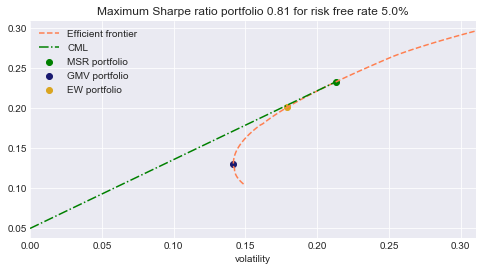

In [81]:
risk_free_rate = 0.05
df, ax = erk.efficient_frontier(90, daily_rets, cov_rets, periods_per_year, risk_free_rate=risk_free_rate, 
                                iplot=True, hsr=True, cml=True, mvp=True, ewp=True)
ax.set_title("Maximum Sharpe ratio portfolio {} for risk free rate {}%".format(np.round(shp,2),risk_free_rate*100))
plt.show()

In [125]:
df.tail()

,0,1,2,3,4,5
88,0.306585,0.294691,0.798117,0.977343,2.775558e-16,0.022657
89,0.311073,0.296842,0.793521,1.000000,1.335500e-16,0.000000
90,0.212923,0.232931,0.859140,0.483833,1.543192e-01,0.361848
91,0.141678,0.130930,0.571223,0.055687,7.898499e-01,0.154463
92,0.179320,0.201360,0.844078,0.333333,3.333333e-01,0.333333


### Maximizing the sharpe ratio = Minimizing volatility when we invest also in a risk free asset

Suppose that along with the set of risky assets there is also a risk-free asset with volatility zero and return equal to the risk-free rate $R_f$. In this case, we may want to minimize the volatility of the portfolio (i.e., the volatility of the part of the portfolio invested in the risky assets, since the the risk-free asset, by definition, is risk free) in which we have allocated some weights $\mathbf{w}$ in the risky assets and the remaining part of our capital, i.e., $1-\mathbf{w}^T\mathbf{1}$, in the risk-free asset:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} + (1 - \mathbf{w}^T\mathbf{1})R_f &= R_0,  \\
\end{cases}
$$
Note that in this case we can **short sell** the assets and we invest all of the capital. 
We define the Lagrangian:
$$
\mathcal{L}(\mathbf{w}, \lambda) := 
\frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w} 
- \lambda\left( \mathbf{w}^T \mathbf{R} + (1-\mathbf{w}^T\mathbf{1})R_f - R_0\right),
$$
and put the partial derivatives to zero:
$$
\begin{cases}
\frac{\partial\mathcal{L}}{\partial \mathbf{w}} &= \frac{1}{2} (2\Sigma \mathbf{w}) - \lambda \mathbf{R} + \lambda R_f \mathbf{1}= 0, \\
\frac{\partial\mathcal{L}}{\partial \lambda} &=  - \mathbf{w}^T \mathbf{R} - (1-\mathbf{w}\mathbf{1})R_f + R_0 = 0, \\
\end{cases}
$$
From the first equation we get:
$$
\mathbf{w} = \lambda \Sigma^{-1}(\mathbf{R} - R_f\mathbf{1}), 
$$
and we can insert it in the second equation:
$$
\left( \lambda\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1}) \right)^T \mathbf{R} + \left( 1 - (\lambda\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1}))^T\mathbf{1}   \right) R_f = R_0
\quad \Longrightarrow\quad 
\lambda = \frac{R_0-R_f}{(\mathbf{R}-R_f\mathbf{1})^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1})}.
$$
We can now put $\lambda$ back into the expression for the weigths:
$$
\mathbf{w}^* 
= \underbrace{ \frac{R_0-R_f}{(\mathbf{R}-R_f\mathbf{1})^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1})} }_{:= r} \Sigma^{-1}(\mathbf{R} - R_f\mathbf{1})
= r \Sigma^{-1}(\mathbf{R} - R_f\mathbf{1}).
$$
We found the otpimal weight allocations to the risky assets. The allocation to the risk-free rate would be then given by 
$1-\mathbf{w^*}^T\mathbf{1}$. 

#### Portfolio return and volatility
Notice that a portfolio with these weigths should give, by definition, a return equal to the target return $R_0$. 
In fact:
$$
\mu_p = \mathbf{w^*}^T \mathbf{R} + (1 - \mathbf{w^*}^T\mathbf{1})R_f 
= r(\mathbf{R}-R_f\mathbf{1})^T\Sigma^{-1}\mathbf{R} + R_f - r(\mathbf{R}-R_f\mathbf{1})^T\Sigma^{-1} R_f \mathbf{1} 
= \underbrace{ r(\mathbf{R}-R_f\mathbf{1})^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1}) }_{= R_0 - R_f}   + R_f  = R_0.
$$
Right. The volatility of the portfolio is given by:
$$
\sigma_p^2 = \mathbf{w^*}^T\Sigma\mathbf{w^*} 
= \left( r \Sigma^{-1}(\mathbf{R} - R_f\mathbf{1}) \right)^T \Sigma \left( r \Sigma^{-1}(\mathbf{R} - R_f\mathbf{1}) \right) 
= r^2 (\mathbf{R} - R_f\mathbf{1})^T \Sigma^{-1}\underbrace{\Sigma\Sigma^{-1}}_{=Id} (\mathbf{R} - R_f\mathbf{1}) 
= \frac{(R_0-R_f)^2}{ \left( (\mathbf{R}-R_f\mathbf{1})^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1}) \right)^2 } 
(\mathbf{R}-R_f\mathbf{1})^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1})
$$
that is:
$$
\sigma_p = \frac{(R_0-R_f)}{ \sqrt{ (\mathbf{R}-R_f\mathbf{1})^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1})} }.
$$

#### Portoflio weigths when full allocation is done to the risky assets (MSR)

If, even in case of risk-free asset, we decide to allocate all the capital to the risky assets we can easily find the weights by normalizing the efficient weights we have found before. In particular, notice that $\mathbf{w}^*$ is proportional to the vector 
$\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1})$ with the constant of proportionality equal to $r$. 
Hence we can define the weigths:
$$
\mathbf{w}_M := \frac{\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1}) }{ \mathbf{1}^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1}) },
$$
where notice that the denominator is simply the sum of the weigths in $\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1})$, i.e., weights in $w_M$ sum to $1$, and correspond to a full allocation of money in the risky assets and zero to the risk-free rate asset. 

Note that the return of such portfolio is given by:
$$
\mu_M = \mathbf{w}_M^T\mathbf{R} = \frac{ (\mathbf{R}-R_f\mathbf{1})^T\Sigma^{-1}\mathbf{R} }{ \mathbf{1}^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1})}, 
$$
while the volatility is:
$$
\sigma_M^2 = \mathbf{w}_M^T \Sigma \mathbf{w}_M 
= \frac{1}{ \left( \mathbf{1}^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1})  \right)^2 } 
(\mathbf{R}-R_f\mathbf{1})^T\underbrace{\Sigma^{-1}\Sigma}_{=Id}\Sigma^{-1} (\mathbf{R}-R_f\mathbf{1}) 
= \frac{(\mathbf{R}-R_f\mathbf{1})^T \Sigma^{-1} (\mathbf{R}-R_f\mathbf{1})}{ \left( \mathbf{1}^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1}) \right)^2 }
\quad \Longrightarrow\quad 
\sigma_M = 
\frac{ \sqrt{(\mathbf{R}-R_f\mathbf{1})^T \Sigma^{-1} (\mathbf{R}-R_f\mathbf{1})}  }{ \mathbf{1}^T\Sigma^{-1}(\mathbf{R}-R_f\mathbf{1})  }.
$$

The portoflio of only risky assets with weights given by $\mathbf{w}_M$ is, by constuction, a portfolio with a minimum volatility lying on the efficient frontier. However, we can see that **it is also the portfolio with the highest Sharpe Ratio**. 

Consider the point on the $(\sigma, \mu)$ plane corresponding to the portfolio where we only allocate money to the risk-free asset, 
i.e. the portfolio with $(\sigma,\mu)=(0,R_f)$, and the portfolio where we only allocate money to the risky asset,
i.e. the portfolio with $(\sigma,\mu)=(\sigma_M,\mu_M)$, where $\sigma_M$ and $\mu_M$ have been found above. 
The line connecting these two portfolio is:
$$
\mu - \mu_M = \frac{\mu_M - R_f}{\sigma_M - 0} (\sigma - \sigma_M) 
\quad\text{and then}\quad
\mu = R_f + \frac{\mu_M - R_f}{\sigma_M} \sigma,
$$
i.e., **this is the Capital Market Line**, and we see that **the slope of the CML is the Sharpe Ratio of the portfolio with return $\mu_M$ and $\sigma_M$**, that is, the minimum volatility portfolio on the efficient frontier with weights given by $\mathbf{w}_M$. Furthermore, from the line we see that such portfolio is also the 
maximum Sharpe Ratio portfolio since:
$$
\max \frac{\mu - R_f}{\sigma} = \frac{\mu_M - R_f}{\sigma_M}.
$$

Since the CML connects the portfolios composed of only the risk-free asset and only the risky assets, every point on the line corresponds to an investmentes in both the risk-free rate and the risky assets. In this case, the weights are given by the $\mathbf{w}^*$ previously found. 

First of all, recall that with our method we can find the weigths of the portfolio with the maximum sharpe ratio:

In [179]:
risk_free_rate = 0.06
optimal_weights = erk.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
optimal_weights

array([0.54475748, 0.06431016, 0.39093236])

Ok. Let us verify our formulas for $\mathbf{w}_M$:

In [180]:
invcov = erk.inverse_df(cov_rets)
ones   = np.repeat(1,3) 
r_rf   = ann_rets - risk_free_rate*ones

In [181]:
w_M = np.dot( invcov, r_rf ) / np.dot( ones, np.dot(invcov, r_rf) )
w_M

array([0.54341264, 0.06476864, 0.39181871])

Yes, they coincide. We implemented these weights in the following method:

In [183]:
erk.weigths_max_sharpe_ratio(cov_rets, r_rf).values

array([0.54341264, 0.06476864, 0.39181871])

Now, let us verify that the portfolio with these weigths has a return and a volatility as in formulas $\mu_M$ and $\sigma_M$:

In [184]:
# return: using the portfolio return method
mu_M = erk.portfolio_return(w_M, ann_rets)
mu_M

0.24723242543150564

In [185]:
# return: using the formula we found
mu_M = np.dot( r_rf, np.dot(invcov, ann_rets) ) / np.dot(ones, np.dot(invcov,r_rf) )
mu_M 

0.24723242543150556

In [186]:
# volatility: using the portfolio vol method
sigma_M = erk.annualize_vol( erk.portfolio_volatility(w_M, cov_rets), periods_per_year)
sigma_M

0.23005195525472716

In [187]:
# volatility: using the formula
sigma_M = np.sqrt( np.dot(r_rf, np.dot(invcov,r_rf)) ) / np.dot(ones, np.dot(invcov,r_rf))
sigma_M = erk.annualize_vol(sigma_M , periods_per_year)
sigma_M

0.2300519552547272

Perfect. Let us now define the $\mathbf{w}^*$ weigths of a portfolio which invest in both the risk-free asset and risky assets:

In [188]:
target_ret = 0.13
wstar = (target_ret - risk_free_rate) / np.dot(r_rf, np.dot(invcov,r_rf)) * np.dot(invcov,r_rf)             
wstar

array([0.20316398, 0.02421485, 0.14648803])

To these weigths we have to add the weigth in the risk-free asset:

In [189]:
np.append( wstar, 1-wstar.sum() )

array([0.20316398, 0.02421485, 0.14648803, 0.62613313])

The last weight is the one in the risk-free asset. 
The return of such a portfolio is, by definition, equal to the target return:

In [190]:
mu_p = erk.portfolio_return( np.append(wstar,1-wstar.sum()) , ann_rets.append(pd.Series(risk_free_rate)) )
mu_p

0.13

Let us see the volatility of such a portfolio:

In [191]:
# using the portfolio_volatility method
erk.annualize_vol( erk.portfolio_volatility(wstar, cov_rets), periods_per_year)

0.0860088033935234

In [192]:
# using the formula
sigma_p = erk.annualize_vol( (target_ret - risk_free_rate) / np.sqrt(np.dot(r_rf, np.dot(invcov,r_rf))), periods_per_year )
sigma_p

0.08600880339352342

Finally, let us verify that all portfolio that are constructed using the weigths $\mathbf{w}^*$ and $1-\mathbf{w}^T\mathbf{1}$ lie on the Capital Market Line. We define a set of target returns, from the original target return of $0.06$ up to the maximum sharpe ratio return $\mu_M$:

In [193]:
target_ret_vec = np.linspace(target_ret,mu_M,20)
wstar = [ (tr - risk_free_rate) / np.dot(r_rf, np.dot(invcov,r_rf)) * np.dot(invcov,r_rf) for tr in target_ret_vec ]         
wstar = [ np.append(wstar[i], 1-wstar[i].sum()) for i in range(len(wstar)) ]
wstar 

[array([0.20316398, 0.02421485, 0.14648803, 0.62613313]),
 array([0.22107181, 0.02634926, 0.15940018, 0.59317876]),
 array([0.23897963, 0.02848367, 0.17231232, 0.56022438]),
 array([0.25688745, 0.03061808, 0.18522446, 0.52727001]),
 array([0.27479528, 0.03275249, 0.1981366 , 0.49431563]),
 array([0.2927031 , 0.0348869 , 0.21104874, 0.46136126]),
 array([0.31061093, 0.03702131, 0.22396088, 0.42840688]),
 array([0.32851875, 0.03915572, 0.23687302, 0.39545251]),
 array([0.34642658, 0.04129013, 0.24978516, 0.36249813]),
 array([0.3643344 , 0.04342454, 0.2626973 , 0.32954376]),
 array([0.38224222, 0.04555895, 0.27560945, 0.29658938]),
 array([0.40015005, 0.04769336, 0.28852159, 0.263635  ]),
 array([0.41805787, 0.04982777, 0.30143373, 0.23068063]),
 array([0.4359657 , 0.05196218, 0.31434587, 0.19772625]),
 array([0.45387352, 0.05409659, 0.32725801, 0.16477188]),
 array([0.47178135, 0.056231  , 0.34017015, 0.1318175 ]),
 array([0.48968917, 0.05836541, 0.35308229, 0.09886313]),
 array([0.5075

In [194]:
mus = [erk.portfolio_return(wstar[i], ann_rets.append(pd.Series(risk_free_rate))) for i in range(len(wstar)) ]
sigmas = [erk.annualize_vol((tr - risk_free_rate) / np.sqrt(np.dot(r_rf, np.dot(invcov,r_rf))), periods_per_year) for tr in target_ret_vec]

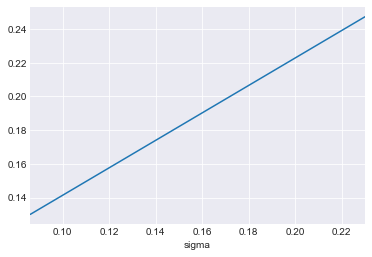

In [198]:
CML = pd.concat([pd.DataFrame(sigmas),pd.DataFrame(mus)], axis=1) 
CML.columns = ["sigma","mu"]
CML.plot.line(x="sigma", y="mu", grid=True, legend=False)
plt.show()